# NTS Net

In [1]:
import gc
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import tarfile
import time
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda:0')

## 1. Dataset 

In [3]:
class CUB2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=True):
        self.root = os.path.expanduser(root)
        self.train = train
        self.transform = transform
        self.loader = loader
        if download:
            self.download()
        if not self.check_integrity():
            raise RuntimeError('Dataset not found or corrupted. You can use download=True to download it')

    def load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ', names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'), sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'), sep=' ', names=['img_id', 'is_training_img'])
        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')
        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def check_integrity(self):
        try:
            self.load_metadata()
        except Exception:
            return False
        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def download(self):
        if self.check_integrity():
            print('Files already downloaded and verified')
            return
        download_url(self.url, self.root, self.filename, self.tgz_md5)
        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

In [4]:
batch_size = 16

transform = transforms.Compose([
    transforms.Resize((600, 600), Image.BILINEAR),
    transforms.RandomCrop((448, 448)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainset = CUB2011(root='./CUB2011', train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
testset = CUB2011(root='./CUB2011', train=False, transform=transform, download=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

0it [00:00, ?it/s]

1150590976it [03:00, 5934937.33it/s]                                

Files already downloaded and verified


## 2. Network

In [5]:
class FeatureExtractorNet(nn.Module):
    def __init__(self, pretrained=True):
        super(FeatureExtractorNet, self).__init__()
        self.layer = nn.Sequential(
            *(list(torchvision.models.resnet50(pretrained=pretrained).children())[:-2])
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2048, 200)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        feature1 = self.layer(x)
        feature2 = self.avgpool(feature1)
        feature2 = feature2.view(feature2.size(0), -1)
        feature2 = self.dropout(feature2)
        out = self.fc(feature2)
        return out, feature1, feature2

In [6]:
class NavigatorNet(nn.Module):
    def __init__(self):
        super(NavigatorNet, self).__init__()
        self.down1 = nn.Conv2d(2048, 128, 3, 1, 1)
        self.down2 = nn.Conv2d(128, 128, 3, 2, 1)
        self.down3 = nn.Conv2d(128, 128, 3, 2, 1)
        self.relu = nn.ReLU()
        self.tidy1 = nn.Conv2d(128, 6, 1, 1, 0)
        self.tidy2 = nn.Conv2d(128, 6, 1, 1, 0)
        self.tidy3 = nn.Conv2d(128, 9, 1, 1, 0)

    def forward(self, extract_feature):
        feature_batch_size = extract_feature.size(0)
        d1 = self.relu(self.down1(extract_feature))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        t1 = self.tidy1(d1).view(feature_batch_size, -1)
        t2 = self.tidy2(d2).view(feature_batch_size, -1)
        t3 = self.tidy3(d3).view(feature_batch_size, -1)
        return torch.cat((t1, t2, t3), dim=1)

In [7]:
class TeacherNet(nn.Module):
    def __init__(self, topN=4):
        super(TeacherNet, self).__init__()
        self.topN = topN
        self.layer = nn.Linear(2048, 200)
        
    def forward(self, part_features, batch_size):
        return self.layer(part_features).view(batch_size, self.topN, -1)

In [8]:
class ScrutinizerNet(nn.Module):
    def __init__(self, catNum=4, topN=4):
        super(ScrutinizerNet, self).__init__()
        self.topN = topN
        self.catNum = catNum
        self.layer = nn.Linear(2048 * (self.catNum + 1), 200)
        
    def forward(self, part_features, extract_feature, batch_size):
        part_feature = part_features.view(batch_size, self.topN, -1)
        part_feature = part_feature[:, :self.catNum, ...].contiguous()
        part_feature = part_feature.view(batch_size, -1)
        out = self.layer(torch.cat([part_feature, extract_feature], dim=1))
        return out

In [9]:
class RegionGeneratorNet(nn.Module):
    def __init__(self, topN=4):
        super(RegionGeneratorNet, self).__init__()
        self.topN = topN
        self.default_anchors_setting = (
            dict(layer='p3', stride=32, size=48, scale=[2 ** (1. / 3.), 2 ** (2. / 3.)], aspect_ratio=[0.667, 1, 1.5]),
            dict(layer='p4', stride=64, size=96, scale=[2 ** (1. / 3.), 2 ** (2. / 3.)], aspect_ratio=[0.667, 1, 1.5]),
            dict(layer='p5', stride=128, size=192, scale=[1, 2 ** (1. / 3.), 2 ** (2. / 3.)], aspect_ratio=[0.667, 1, 1.5]),
        )
        self.edge_anchors = self.get_edge_anchors()
        
    def forward(self, x, rpn_score):
        batch_size = x.size(0)
        x_pad = F.pad(x, (224, 224, 224, 224), mode='constant', value=0)
        all_cdds = []
        for data in rpn_score.data.cpu().numpy():
            all_cdds.append(np.concatenate((data.reshape(-1, 1), self.edge_anchors.copy(), np.arange(0, len(data)).reshape(-1, 1)), axis=1))
        top_n_cdds = []
        for all_cdd in all_cdds:
            top_n_cdds.append(self.nms(all_cdd, iou_thresh=0.25))
        top_n_cdds = np.array(top_n_cdds)
        top_n_index = torch.from_numpy(top_n_cdds[:, :, -1].astype(np.int)).cuda()
        top_n_prob = torch.gather(rpn_score, dim=1, index=top_n_index)
        part_imgs = torch.zeros([batch_size, self.topN, 3, 224, 224]).cuda()
        for i in range(batch_size):
            for j in range(self.topN):
                [y0, x0, y1, x1] = top_n_cdds[i][j, 1:5].astype(np.int)
                part_imgs[i:i+1, j] = F.interpolate(x_pad[i:i+1, :, y0:y1, x0:x1], size=(224, 224), mode='bilinear', align_corners=True)
        part_imgs = part_imgs.view(batch_size * self.topN, 3, 224, 224)
        return part_imgs, top_n_prob

    def get_edge_anchors(self):
        edge_anchors = np.zeros((0, 4), dtype=np.float32)
        input_shape = np.array((448, 448), dtype=int)
        for anchor_info in self.default_anchors_setting:
            output_map_shape = np.ceil(input_shape.astype(np.float32) / anchor_info['stride']).astype(np.int)
            output_shape = tuple(output_map_shape) + (4,)
            start = anchor_info['stride'] / 2.
            y = np.arange(start, start + anchor_info['stride'] * output_shape[0], anchor_info['stride']).reshape(output_shape[0], 1)
            x = np.arange(start, start + anchor_info['stride'] * output_shape[1], anchor_info['stride']).reshape(1, output_shape[1])
            center_anchor_map_template = np.zeros(output_shape, dtype=np.float32)
            center_anchor_map_template[:, :, 0] = y
            center_anchor_map_template[:, :, 1] = x
            for scale in anchor_info['scale']:
                for aspect_ratio in anchor_info['aspect_ratio']:
                    center_anchor_map = center_anchor_map_template.copy()
                    center_anchor_map[:, :, 2] = anchor_info['size'] * scale / float(aspect_ratio) ** 0.5
                    center_anchor_map[:, :, 3] = anchor_info['size'] * scale * float(aspect_ratio) ** 0.5
                    edge_anchor_map = np.concatenate((center_anchor_map[..., :2] - center_anchor_map[..., 2:4] / 2.,
                                                      center_anchor_map[..., :2] + center_anchor_map[..., 2:4] / 2.), axis=-1)
                    edge_anchors = np.concatenate((edge_anchors, edge_anchor_map.reshape(-1, 4)))
        return (edge_anchors + 224).astype(np.int)
    
    def nms(self, cdds, iou_thresh=0.25):
        cdds = cdds.copy()
        indices = np.argsort(cdds[:, 0])
        cdds = cdds[indices]
        cdd_results = []
        res = cdds
        while res.any():
            cdd = res[-1]
            cdd_results.append(cdd)
            if len(cdd_results) == self.topN:
                return np.array(cdd_results)
            res = res[:-1]
            start_max = np.maximum(res[:, 1:3], cdd[1:3])
            end_min = np.minimum(res[:, 3:5], cdd[3:5])
            lengths = end_min - start_max
            intersec_map = lengths[:, 0] * lengths[:, 1]
            intersec_map[np.logical_or(lengths[:, 0] < 0, lengths[:, 1] < 0)] = 0
            iou_map_cur = intersec_map/((res[:, 3]-res[:, 1])*(res[:, 4]-res[:, 2])+(cdd[3]-cdd[1])*(cdd[4]-cdd[2])-intersec_map)
            res = res[iou_map_cur < iou_thresh]
        return np.array(cdd_results)

In [10]:
class NTSNet(nn.Module):
    def __init__(self, topN=4):
        super(NTSNet, self).__init__()
        self.topN = topN
        self.feature_extractor = FeatureExtractorNet(pretrained=True)
        self.navigator = NavigatorNet()
        self.teacher = TeacherNet(topN=topN)
        self.scrutinizer = ScrutinizerNet(topN=topN)
        self.region_generator = RegionGeneratorNet(topN=topN)

    def forward(self, x):
        batch_size = x.size(0)
        r_out, n_feature, s_feature = self.feature_extractor(x)
        rpn_score = self.navigator(n_feature.detach())
        part_imgs, top_n_prob = self.region_generator(x, rpn_score)        
        _, _, part_features = self.feature_extractor(part_imgs.detach())
        t_out = self.teacher(part_features, batch_size)
        s_out = self.scrutinizer(part_features, s_feature, batch_size)
        return r_out, t_out, s_out, top_n_prob

## 3. Loss Function

In [11]:
def top_n_loss_fn(score, outputs, targets, batch_size):
    temp = F.log_softmax(outputs, -1)
    temp_loss = []
    for i in range(outputs.size(0)):
        temp_loss.append(-temp[i][targets[i].item()])
    score_targets = torch.stack(temp_loss).view(batch_size, 6)
    
    all_loss = Variable(torch.zeros(1).cuda())
    for i in range(6):
        pivot = score[:, i].unsqueeze(1)
        loss = (1 - pivot + score) * (score_targets > score_targets[:, i].unsqueeze(1)).type(torch.cuda.FloatTensor)
        all_loss += torch.sum(F.relu(loss))
    return all_loss / score.size(0)

## 4. Train Function

In [12]:
def train(trainloader, model, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        optimizer['r'].zero_grad()
        optimizer['n'].zero_grad()
        optimizer['t'].zero_grad()
        optimizer['s'].zero_grad()

        out, teacher_out, scrutinizer_out, top_n_prob = model(data)
        teacher_out = teacher_out.view(batch_size * 6, -1)
        teacher_target= target.unsqueeze(1).repeat(1, 6).view(-1)
        
        r_loss = loss_fn(out, target)
        t_loss = loss_fn(teacher_out, teacher_target)
        s_loss = loss_fn(scrutinizer_out, target)
        top_n_loss = top_n_loss_fn(top_n_prob, teacher_out, teacher_target, batch_size)
        loss = r_loss + t_loss + s_loss + top_n_loss
        total_loss += loss.item()
        loss.backward()
        
        optimizer['r'].step()
        optimizer['n'].step()
        optimizer['t'].step()
        optimizer['s'].step()
    average_loss = total_loss / (batch_idx + 1)
    return average_loss

In [13]:
def evaluate(testloader, model, loss_fn, device):
    with torch.no_grad():
        model.eval()
        correct = 0.0
        total_loss = 0
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(device), target.to(device)
            _, _, outputs, _ = model(data)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).cpu().sum().detach().numpy()
            loss = loss_fn(outputs, target)
            total_loss += loss.item()
        accuracy = correct * 100.0 / len(testloader.dataset)
        average_loss = total_loss / (batch_idx + 1)
    return average_loss, accuracy

In [14]:
def fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, device):
    train_accs = []
    train_losses = []
    test_accs = []
    test_losses = []

    print('Fit start')
    start_time = time.time()
    for epoch in range(n_epochs):
        train_loss= train(train_loader, model, loss_fn, optimizer, device=device)
        _, train_accuracy = evaluate(train_loader, model, loss_fn, device=device)
        
        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                                n_epochs, train_loss, train_accuracy)
        print(message)

        test_loss, test_accuracy = evaluate(test_loader, model, loss_fn, device=device)
        message = 'Epoch: {}/{}. Validation set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(epoch+1, \
                                                               n_epochs, test_loss, test_accuracy)
        print(message)
        print("Cost:", time.time() - start_time)
        
        train_accs.append(train_accuracy)
        train_losses.append(train_loss)
        test_accs.append(test_accuracy)
        test_losses.append(test_loss)
        
        scheduler['r'].step()
        scheduler['n'].step()
        scheduler['t'].step()
        scheduler['s'].step()
    print('Fit end')
    return train_accs, train_losses, test_accs, test_losses

In [15]:
def show_curve(ys, title):
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} Curve:'.format(title))
    plt.xlabel('Epoch')
    plt.ylabel('{} Value'.format(title))
    plt.show()

## 5. Train

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

100%|██████████| 102502400/102502400 [00:01<00:00, 60748874.80it/s]

Fit start
Epoch: 1/10. Train set: Average loss: 29.5713, Accuracy: 26.3597
Epoch: 1/10. Validation set: Average loss: 3.1081, Accuracy: 23.5589
Cost: 574.0226299762726
Epoch: 2/10. Train set: Average loss: 21.7526, Accuracy: 57.3574
Epoch: 2/10. Validation set: Average loss: 1.7051, Accuracy: 51.6051
Cost: 1148.9625890254974
Epoch: 3/10. Train set: Average loss: 16.8709, Accuracy: 66.3163
Epoch: 3/10. Validation set: Average loss: 1.4543, Accuracy: 58.0083
Cost: 1724.8854219913483
Epoch: 4/10. Train set: Average loss: 15.0482, Accuracy: 76.9937
Epoch: 4/10. Validation set: Average loss: 1.1075, Accuracy: 68.2775
Cost: 2297.712609052658
Epoch: 5/10. Train set: Average loss: 15.1249, Accuracy: 82.5492
Epoch: 5/10. Validation set: Average loss: 1.0127, Accuracy: 72.1781
Cost: 2867.2944281101227
Epoch: 6/10. Train set: Average loss: 14.2782, Accuracy: 86.2362
Epoch: 6/10. Validation set: Average loss: 0.9361, Accuracy: 75.0431
Cost: 3433.647276163101
Epoch: 7/10. Train set: Average loss: 1

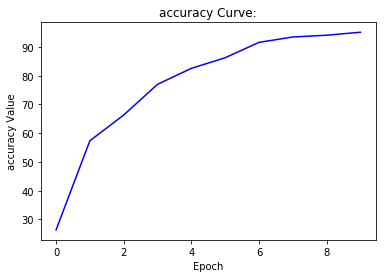

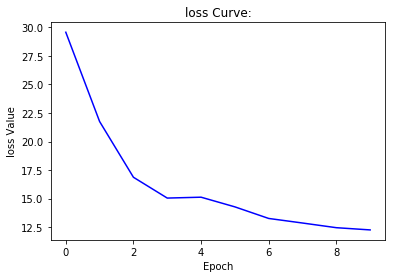

In [16]:
n_epochs = 10
learning_rate = 0.001

model = NTSNet(topN=6).to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = dict()
optimizer['r'] = torch.optim.SGD(model.feature_extractor.parameters(), lr=learning_rate, momentum=0.9)
optimizer['n'] = torch.optim.SGD(model.navigator.parameters(), lr=learning_rate, momentum=0.9)
optimizer['t'] = torch.optim.SGD(model.teacher.parameters(), lr=learning_rate, momentum=0.9)
optimizer['s'] = torch.optim.SGD(model.scrutinizer.parameters(), lr=learning_rate, momentum=0.9)

scheduler = dict()
scheduler['r'] = torch.optim.lr_scheduler.StepLR(optimizer['r'], step_size=6, gamma=0.5)
scheduler['n'] = torch.optim.lr_scheduler.StepLR(optimizer['n'], step_size=6, gamma=0.5)
scheduler['t'] = torch.optim.lr_scheduler.StepLR(optimizer['t'], step_size=6, gamma=0.5)
scheduler['s'] = torch.optim.lr_scheduler.StepLR(optimizer['s'], step_size=6, gamma=0.5)
                                                           
train_accs, train_losses, test_accs, test_losses = fit(trainloader, testloader, model, loss_fn, optimizer, scheduler, n_epochs, device)
show_curve(train_accs, 'accuracy')
show_curve(train_losses, 'loss')

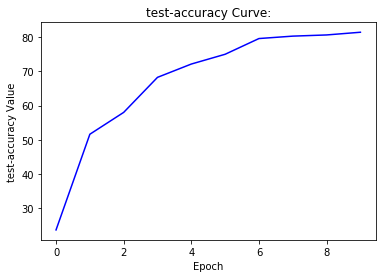

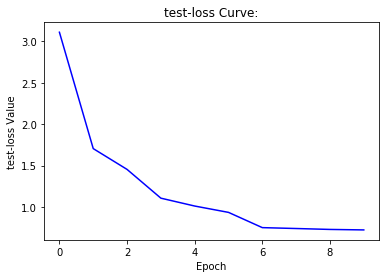

In [18]:
show_curve(test_accs, 'test-accuracy')
show_curve(test_losses, 'test-loss')